In [1]:
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt


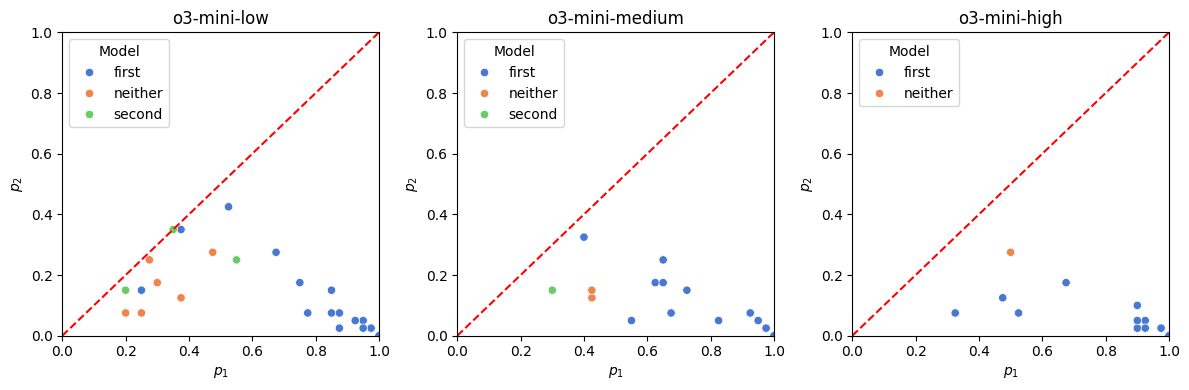

In [7]:
aime24df = pd.read_parquet("hf://datasets/Maxwell-Jia/AIME_2024/aime_2024_problems.parquet")

def sort_key(file_name):
    match = re.search(r'(\d+)\.csv$', file_name)
    return int(match.group(1)) if match else -1

def process_folder(folder_path):
    csv_files = sorted(glob.glob(f"{folder_path}/*.csv"), key=sort_key)
    results = []

    for csv in csv_files:
        df = pd.read_csv(csv)
        target = aime24df.iloc[int(csv.split("/")[-1].split(".")[0])].Answer
        value_counts = df['answer'].value_counts(normalize=True)
        answers = value_counts.nlargest(2).index.tolist()
        while len(answers) < 2:
            answers.append(None)

        p_max = value_counts.max()
        p_second = value_counts.nlargest(2).iloc[1] if len(value_counts) > 1 else 0
        entropy = -(value_counts * np.log2(value_counts)).sum()
        file_index = int(re.search(r'(\d+)\.csv$', csv).group(1))
        if target == answers[0]:
            colorlabel = "first"
        elif target == answers[1]:
            colorlabel = "second"
        else:
            colorlabel = "neither"
        results.append({'file_index': file_index, 'p_max': p_max, 'p_second': p_second, 'entropy': entropy, 'colorlabel': colorlabel, })

    results_df = pd.DataFrame(results)
    return results_df

# Process each folder
folders = ["../../aime24/o3minilow-aime24-vote", "../../aime24/o3minimedium-aime24-vote", "../../aime24/o3minihigh-aime24-vote"]
all_results = []

for folder in folders:
    folder_results = process_folder(folder)
    folder_results['model'] = folder.split('/')[-1]
    all_results.append(folder_results)

# Combine all results into a single dataframe
combined_results_df = pd.concat(all_results, ignore_index=True)

# combined_results_df

unique_models = combined_results_df['model'].unique()

plt.figure(figsize=(12, 4))
# plt.suptitle("Scatter Plot between p_1 and p_2")

for i, model_name in enumerate(unique_models):
    model_name2 = {
        "o3minilow": "o3-mini-low",
        "o3minimedium": "o3-mini-medium",
        "o3minihigh": "o3-mini-high",
    }[model_name.split('-')[0]]

    plt.subplot(1, 3, i + 1)
    model_df = combined_results_df[combined_results_df['model'] == model_name]
    sns.scatterplot(data=model_df, x='p_max', y='p_second', hue='colorlabel', palette='muted')
    # plt.axvspan(0.3, 0.5, color='yellow', alpha=0.3)
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Add y=x line
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title(model_name2)
    plt.xlabel(r'$p_{1}$')
    plt.ylabel(r'$p_{2}$')
    plt.legend(title='Model')

plt.tight_layout()
plt.savefig("./Untitled.pdf", dpi=300)
plt.show()


In [ ]:
print("""
Figure X. Scatterplot for the two most frequent responses by Open AI o3-mini reasoning models.

When p_1 is lower than 0.5, neither of the most frequent responses are likely not to be answer.
This observation justifies our approaches to allow early stopping by accepting H_0, concluding there's no dominating response, even with a weak evidence.
""".strip())